# 2D Capillary Rise
![2DCapillaryRise domain configuration](2DCapillaryRise.png)

The process of liquid flowing through narrow spaces, known as capillary action, has been studied profoundly. The process can be observed in the distribution of water from plants’ roots to the rest of the body, the rising of liquids in porous media such as paper, and oil extraction from reservoirs, among others.

In this validation study, we consider the rising of a liquid column between two planar surfaces. We present the results of the mesh convergence study of a 2D capillary rise with no-slip and resolved partial slip boundary condition. We present the comparison of the plicRDF-isoAdvector method with other numerical methods, 1. the OpenFOAM solver interTrackFoam, an Arbitrary Lagrangian-Eulerian (ALE) method, 2. the Free Surface 3D (FS3D), an in-house two-phase flow solver implying the geometric Volume-of-Fluid (VOF) method, 3. the OpenFOAM-based algebraic VOF solver, interFoam, 4. the Bounded Support Spectral Solver (BoSSS) is based on the extended discontinuous Galerkin method. As discussed by [Dründing et. al.](https://doi.org/10.1016/j.apm.2020.04.020), the dynamics of capillary rise can be controlled by a non-dimensionless group, $\Omega$, defined as

\begin{equation}
\Omega = \sqrt{\frac{9\sigma\cos\theta \mu^2}{\rho^3g^2R^5}}.
\end{equation}

The capillary's rise behavior (monotonic ($\Omega>2$) or oscillatory ($\Omega \leq 2$)) depends on the choice of $\Omega$ . The height of the liquid column is estimated by Jurin’s law as

\begin{equation}
h_{Jurin,2D} = \frac{\sigma \cos{\theta}}{R\rho g},
\label{eq:Jurins-height}
\end{equation}

where $\sigma$ is the surface tension coefficient, $R$ is the radius of the capillary, $\rho$ is the density of the liquid, $g$ is the gravitational acceleration, and $\theta$ is the contact angle. [Dründing et. al.](https://doi.org/10.1016/j.ijmultiphaseflow.2020.103210) the liquid volume in the interface region and calculated the corrected stationary capillary height $h$ as

\begin{equation}
h = h_{Jurin,2D} -\frac{R}{2\cos\theta} \left(2-sin\theta - \frac{\sin^{-1}(\cos\theta)}{\cos\theta}\right).
\label{eq:corrected-capillary-height}
\end{equation}

In [1]:
import numpy as np
from scipy.optimize import fsolve
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import csv
import pandas as pd
import vtk
sys.path.append(os.path.join(os.getcwd(), '../modules'))
print('modules path: ', os.path.join(os.getcwd(), '../modules'))
from capillary_funcs import Funcs

sin =np.sin
cos= np.cos
pi = np.pi
contact_angle =30
theta =np.deg2rad(contact_angle)
R0 = 0.005
eps = 1e-10

rcParams["figure.dpi"] = 600
fontSize =12

#Reference solution
#Jurin's height approximation for this casae setup
h_j=4*R0
print('h_j: ' + str(h_j))
h_cap = (R0/2/math.cos(theta))  * (2-sin(theta) - (math.asin(cos(theta)) /cos(theta)))
print('h_cap: ' + str(h_cap))
#stationary rise height
h_apex = h_j-h_cap
print('h_apex: ' + str(h_apex))

surfaceTensionModel = 'RDF' #surface tension model chosen for the simulations {heightFunction, RDF, fitParaboloid}
dataFolder = '/postProcessing/' #folder with .csv files


modules path:  /home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/../modules
h_j: 0.02
h_cap: 0.0008394685149335336
h_apex: 0.019160531485066468


## Mesh convergence, $\Omega = 1$

{0: {'STM': 'RDF', 'ny': 64, 'nx': 16}, 5: {'STM': 'RDF', 'ny': 128, 'nx': 32}, 10: {'STM': 'RDF', 'ny': 256, 'nx': 64}, 15: {'STM': 'RDF', 'ny': 512, 'nx': 128}}
Variant's list:  ['0', '5', '10', '15']
number of cells per diameter  [16, 32, 64, 128]
['/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/testOmega1_00000_case/postProcessing/height.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/testOmega1_00005_case/postProcessing/height.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/testOmega1_00010_case/postProcessing/height.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/testOmega1_00015_case/postProcessing/height.csv']
[16, 32, 64, 128]


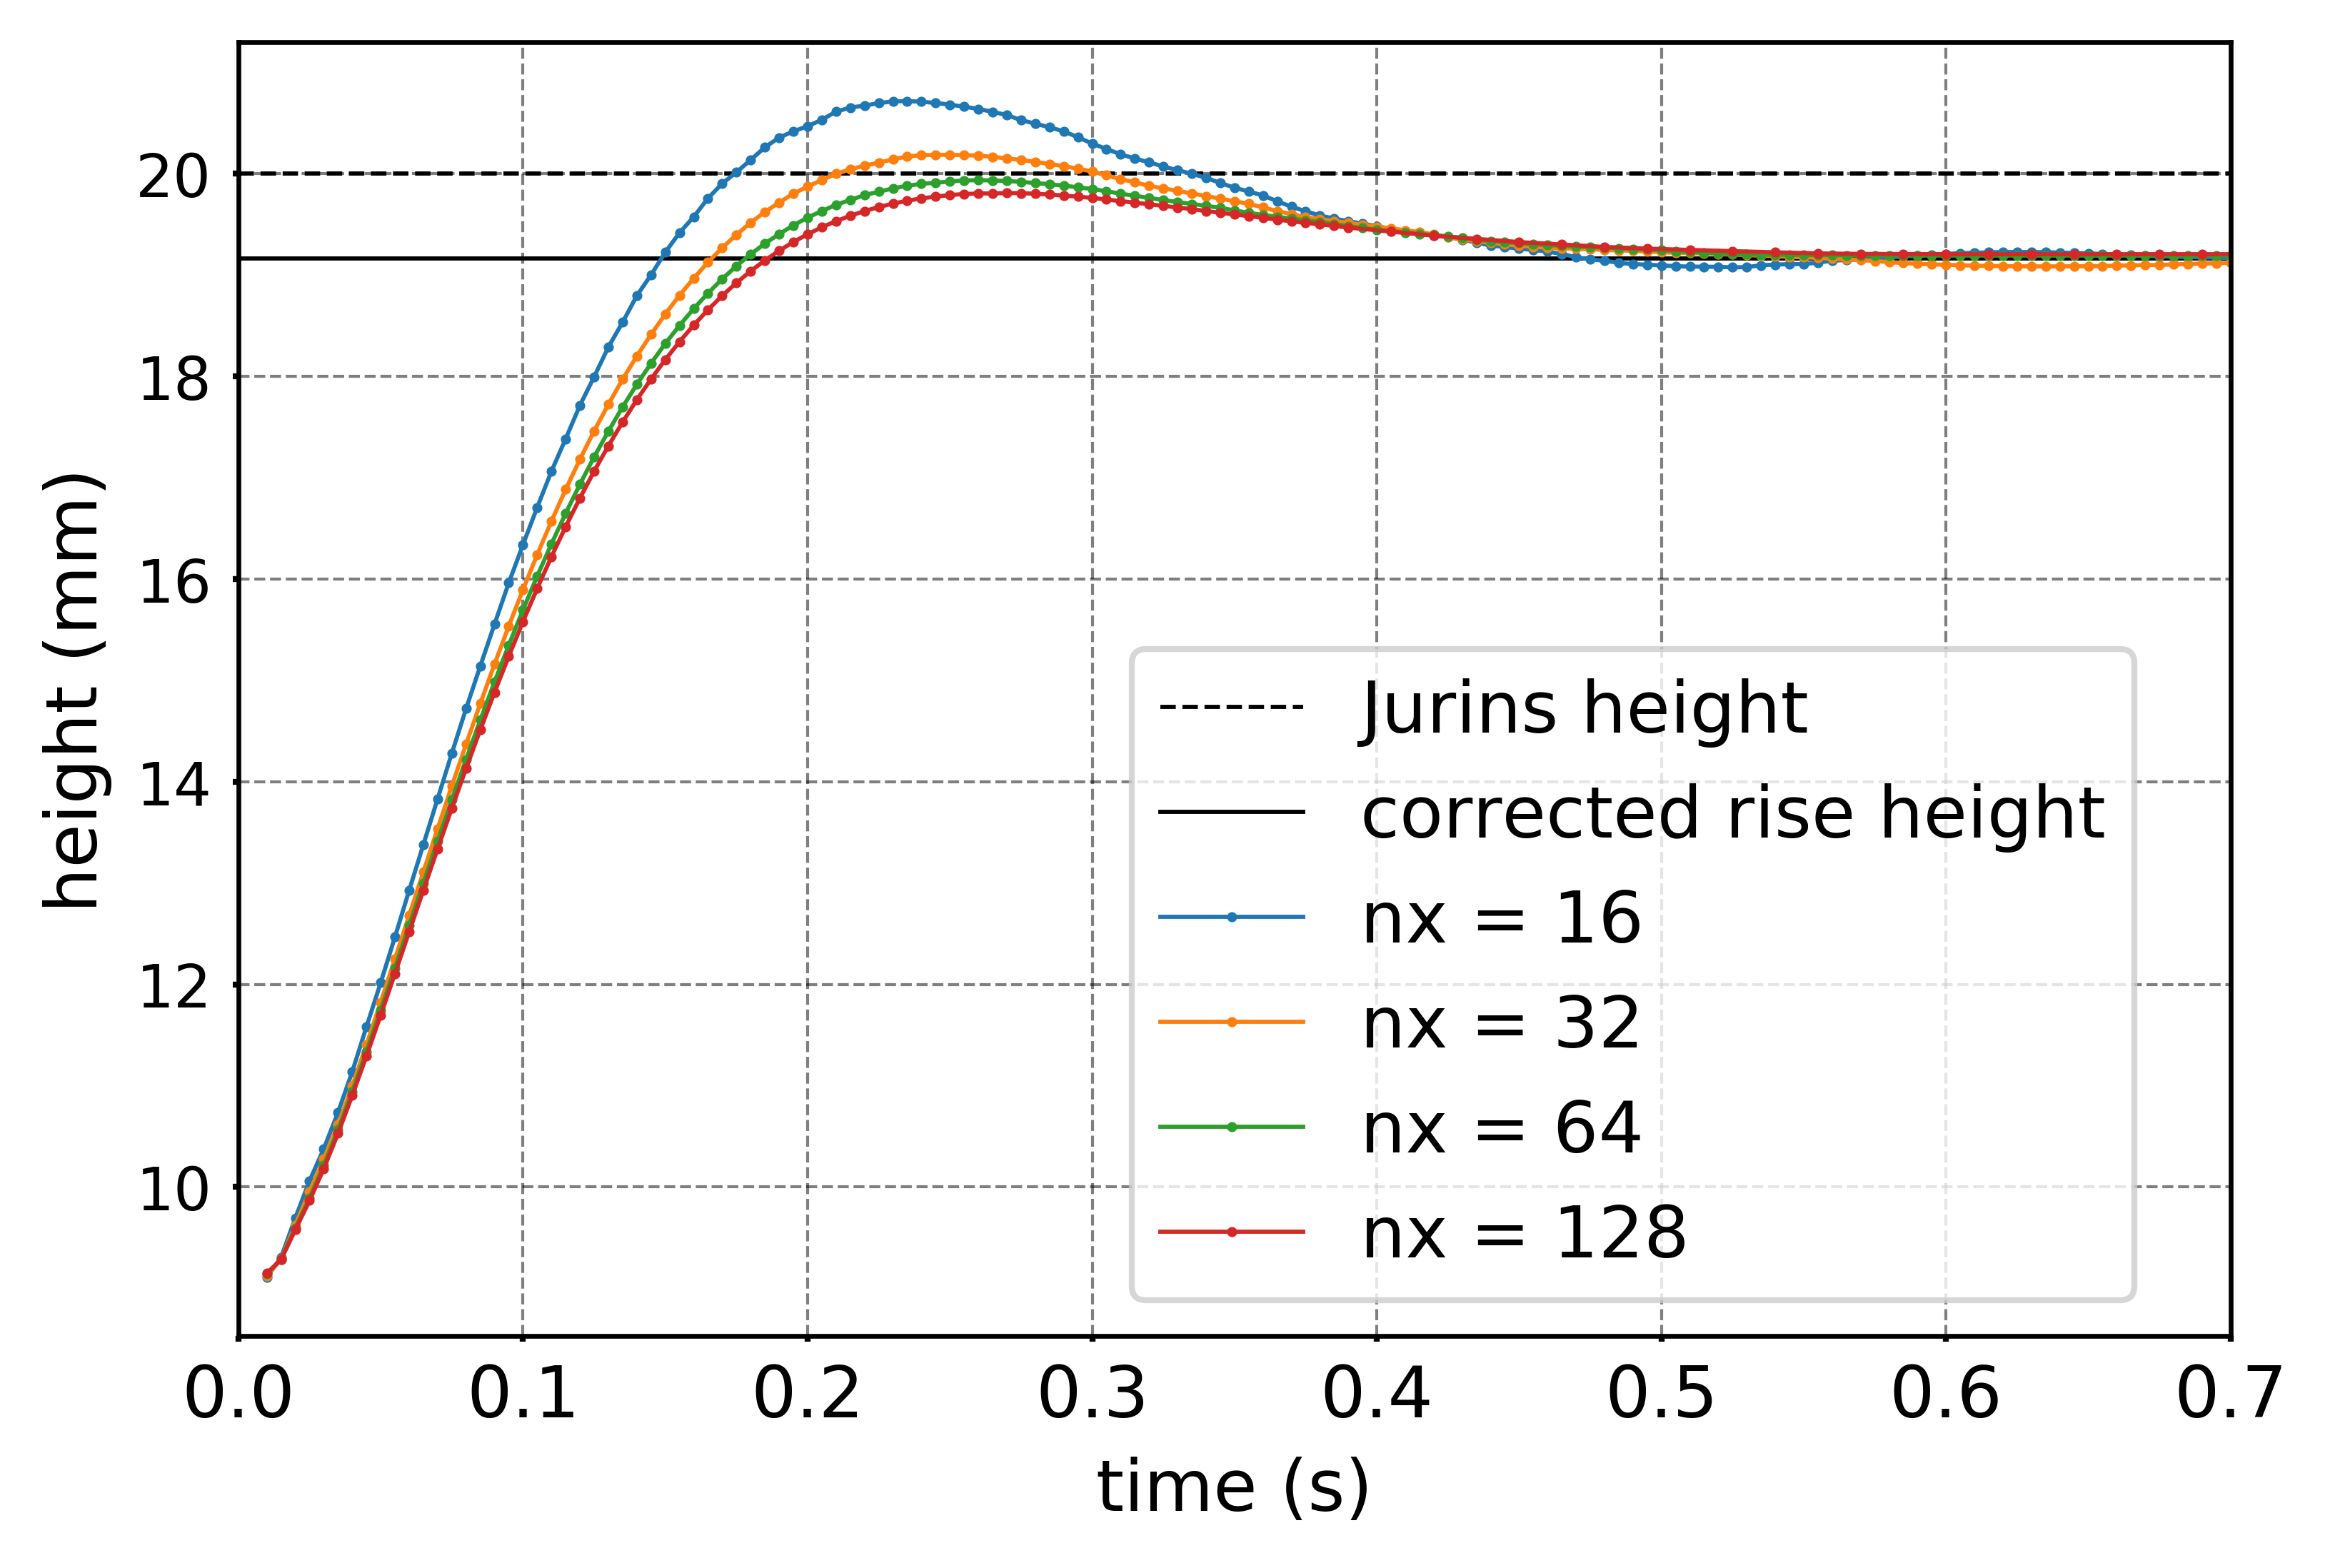

In [2]:
calcHeights = False #True if the simulations are run again and need to write the height.csv from vtk files
pattern = "testOmega1"

#Reference solution line
plt.axhline(h_j*1000.0, color='black', linewidth=0.7,linestyle='dashed', label = "Jurins height")
#Reference solution line
plt.axhline(h_apex*1000.0, color='black', linewidth=0.7, label = "corrected rise height")

##################################################################################################################
#File structure

#read the variation-file to get the parameters map that is saved using pyFOAM
var_Map = Funcs.fileMapping(pattern, surfaceTensionModel)
print(var_Map)

nX= [] # number of cells in x direction used for simulations taken from the variation file
stm = [] # surface tension models in all cases,taken from the variation file
var_list = [] # variance number of the parametric study of a specific case


for key, value in var_Map.items():
    stm_map = str(value).split(', ')[0][:-1] #surface tension model map
    stm.append(stm_map.split(': ')[1][1:])
    nx_map = str(value).split(', ')[2][:-1] #nX map
    nX.append(int(nx_map.split(': ')[1][0:]))
    var_list.append(str(key)) 
print('Variant\'s list: ', var_list)
print("number of cells per diameter ", nX)

vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', pattern, var_list)
heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', pattern, var_list)
print(heightFileNames)

###############################################################################################################

Funcs.writeHeightFile(calcHeights, vtk_folders, heightFileNames)

#Plot equilibrium spread against static contact angle
cellsPerRadius = nX
print(cellsPerRadius)

for idx, heightFile in enumerate(heightFileNames):
    pd.set_option('display.float_format', lambda x: '%.1f' % x)
    df = pd.read_csv(heightFile, index_col = 0)
    plt.plot(df, linewidth=0.7, label='nx = ' + str(cellsPerRadius[idx]),marker='o', markersize=0.7)
    plt.grid(b=True, which='major', color='black',linestyle='dashed', alpha=0.5, lw=0.5)
    plt.grid(b=True, which='minor', color='black', alpha=0.5, lw=0.5)
    plt.tick_params(axis='both', direction='out', length=1, width=1,  grid_color='black', grid_alpha=0.5)
    #plt.title(r'Capillary height', fontsize=fontSize)
    plt.xlabel("time (s)" ,color='black',fontsize=fontSize)
    plt.ylabel("height (mm)",color='black',fontsize=fontSize)
    plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0), ncol=1, fontsize=fontSize)
    plt.xticks(color='black',size = fontSize)
    plt.xlim([0, 0.7])
    plt.ticklabel_format(axis="y", style='sci', useOffset=True)
    plt.rc('font', size=fontSize)
       
plt.savefig('capillary-rise-convergence-study-Omega_1'+'.pdf', bbox_inches='tight')
plt.savefig('capillary-rise-convergence-study-Omega_1'+'.png', bbox_inches='tight')
plt.show()
#######################################################################################


## Mesh convergence, No-slip BC

{0: {'STM': 'RDF', 'ny': 64, 'nx': 16}, 5: {'STM': 'RDF', 'ny': 128, 'nx': 32}, 10: {'STM': 'RDF', 'ny': 256, 'nx': 64}, 15: {'STM': 'RDF', 'ny': 512, 'nx': 128}}
Variant's list:  ['0', '5', '10', '15']
number of cells per diameter  [16, 32, 64, 128]
['/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/testU0_00000_case/postProcessing/height.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/testU0_00005_case/postProcessing/height.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/testU0_00010_case/postProcessing/height.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/testU0_00015_case/postProcessing/height.csv']
[16, 32, 64, 128]


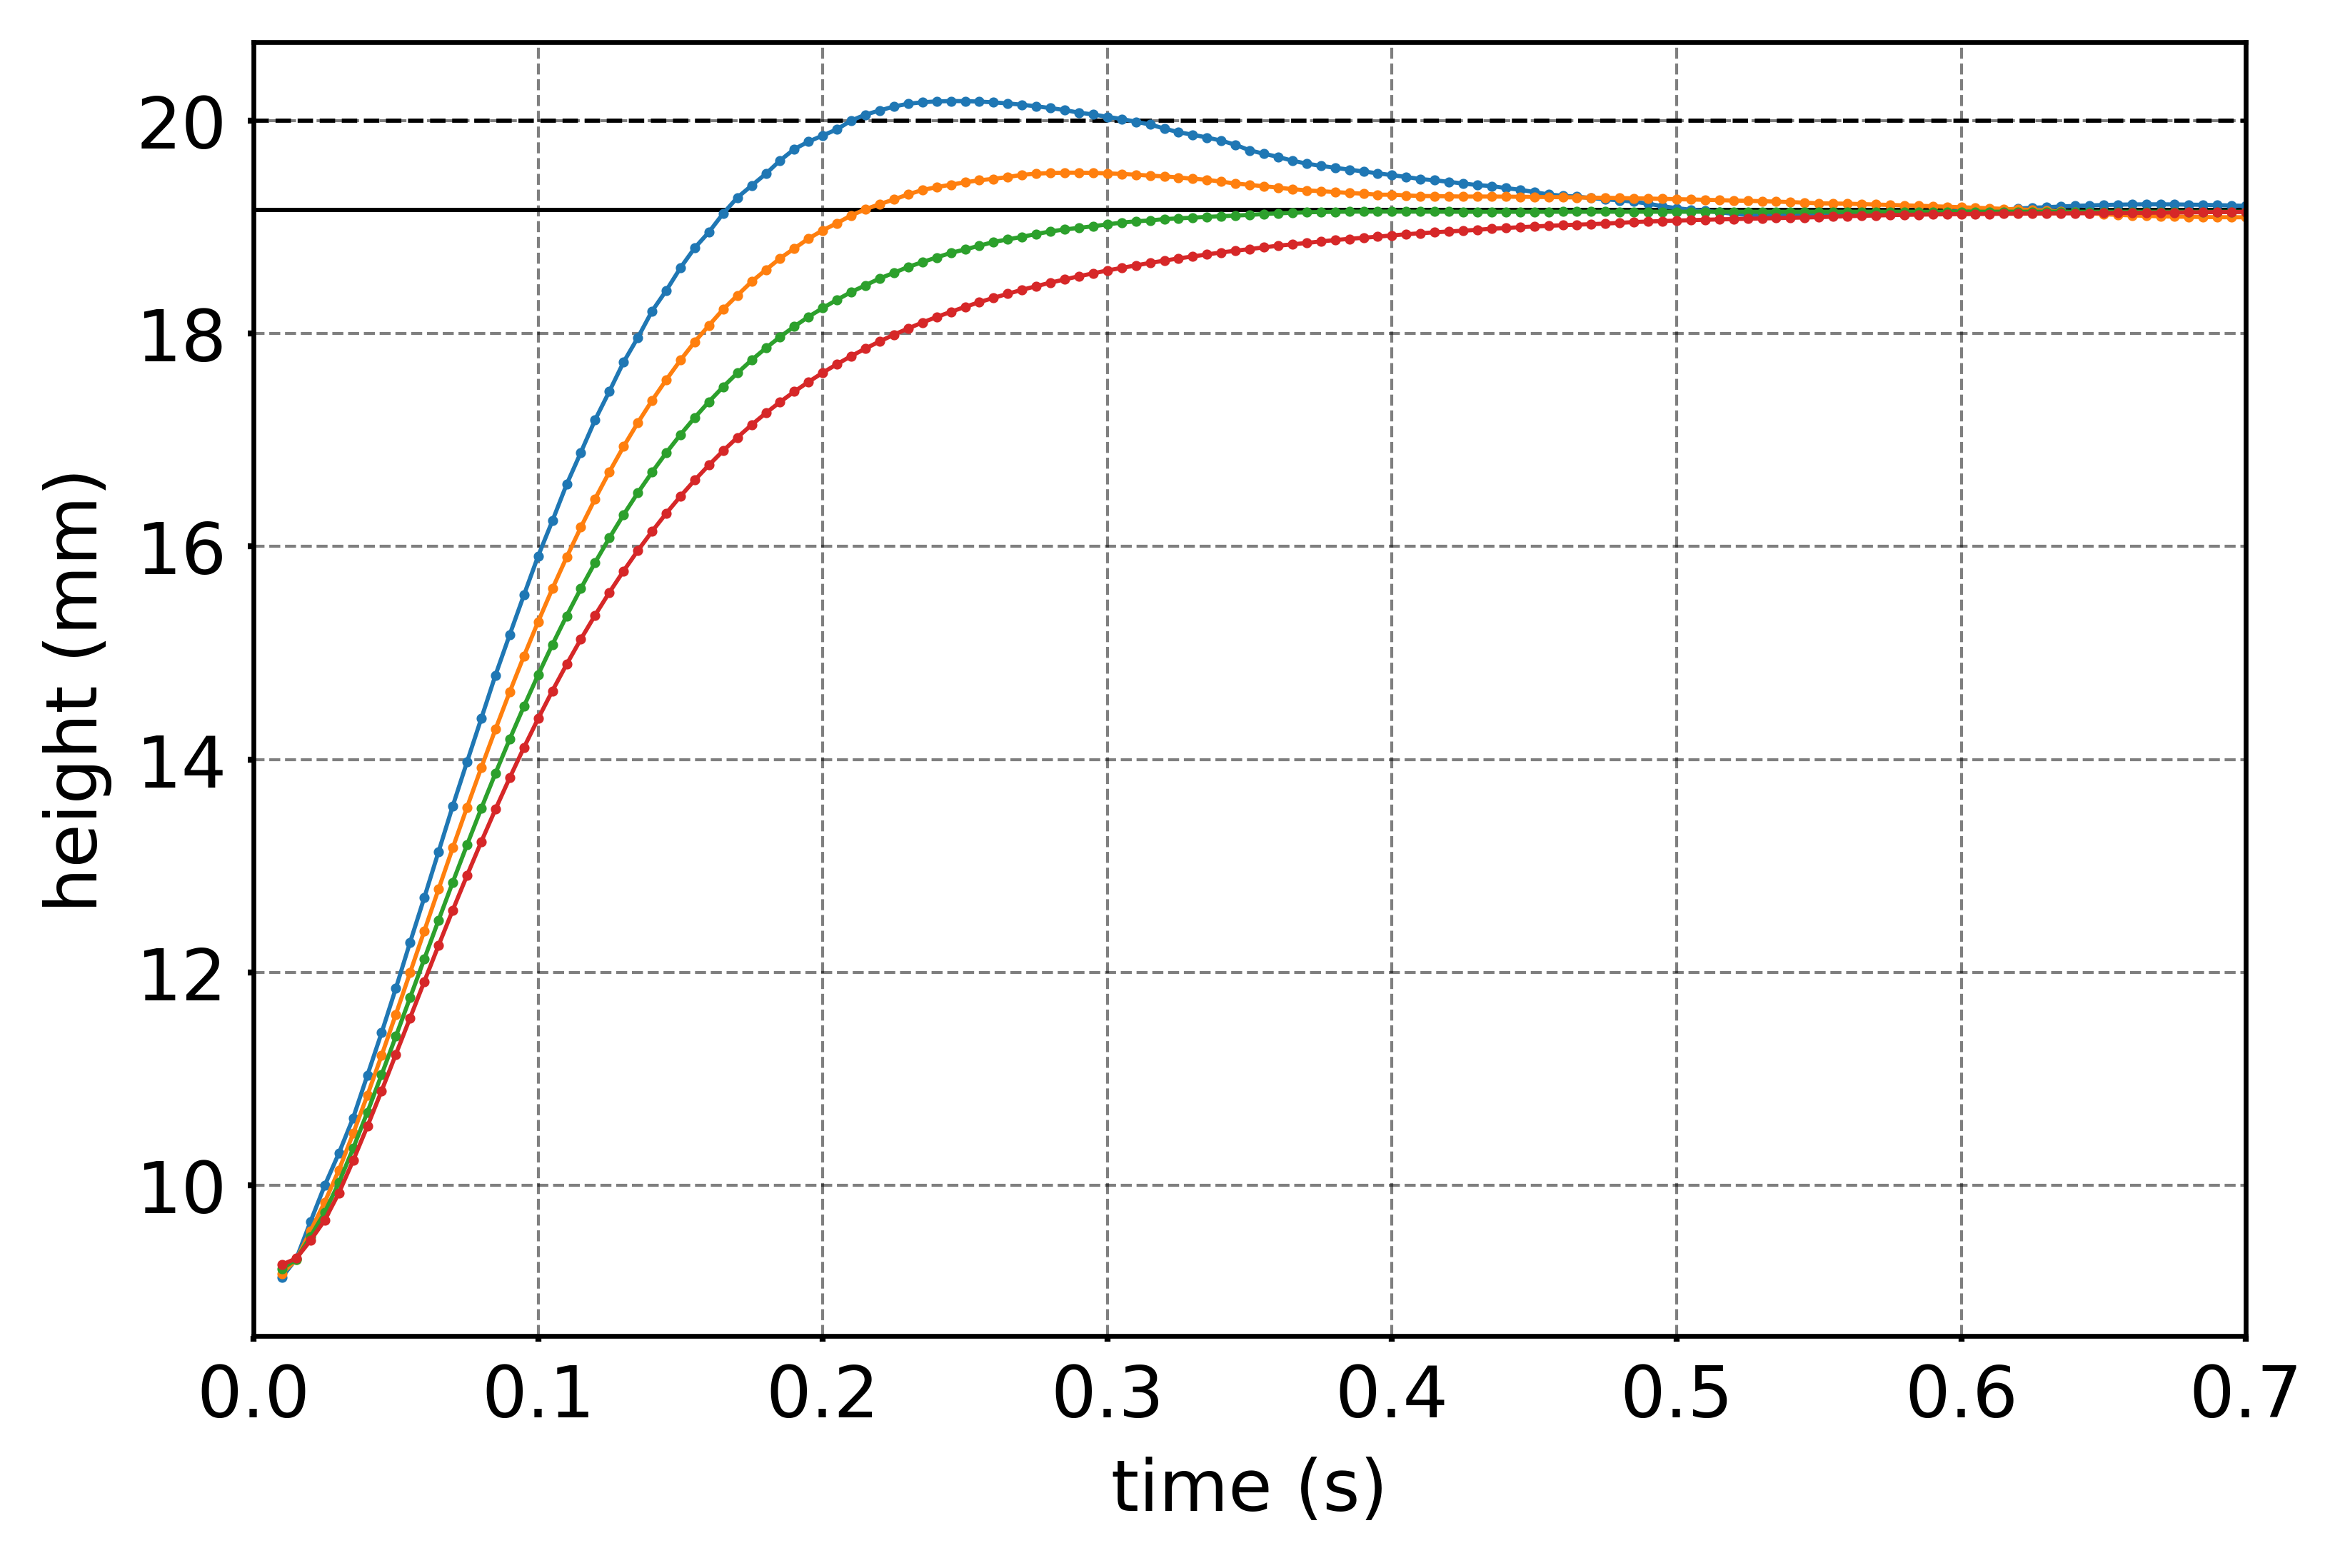

In [3]:
calcHeights = False #True if the simulations are run again and need to write the height.csv
pattern = 'testU0'

#Reference solution line
plt.axhline(h_j*1000.0, color='black', linewidth=0.7,linestyle='dashed', label = "Jurins height")
#Reference solution line
plt.axhline(h_apex*1000.0, color='black', linewidth=0.7, label = "corrected rise height")

###################################################################################################################    
#File structure

#read the variation-file to get the parameters map that is saved using pyFOAM
var_Map = Funcs.fileMapping(pattern, surfaceTensionModel)
print(var_Map)

nX= [] # number of cells in x direction used for simulations taken from the variation file
stm = [] # surface tension models in all cases,taken from the variation file
var_list = [] # variance number of the parametric study of a specific case


for key, value in var_Map.items():
    stm_map = str(value).split(', ')[0][:-1] #surface tension model map
    stm.append(stm_map.split(': ')[1][1:])
    nx_map = str(value).split(', ')[2][:-1] #nX map
    nX.append(int(nx_map.split(': ')[1][0:]))
    var_list.append(str(key)) 
print('Variant\'s list: ', var_list)
print("number of cells per diameter ", nX)

vtk_folders = Funcs.fileStructure(dataFolder, 'surfaces/', pattern, var_list)
heightFileNames = Funcs.fileStructure(dataFolder, 'height.csv', pattern, var_list)
print(heightFileNames)

##################################################################################################################

Funcs.writeHeightFile(calcHeights, vtk_folders, heightFileNames)

#Plot equilibrium spread against static contact angle
cellsPerRadius = nX
print(cellsPerRadius)

for idx, heightFile in enumerate(heightFileNames):
    pd.set_option('display.float_format', lambda x: '%.1f' % x)
    df = pd.read_csv(heightFile, index_col = 0)  
    plt.plot(df, linewidth=0.7, label='nx = ' + str(cellsPerRadius[idx]), marker='o', markersize=0.7)
    plt.grid(b=True, which='major', color='black',linestyle='dashed', alpha=0.5, lw=0.5)
    plt.grid(b=True, which='minor', color='black', alpha=0.5, lw=0.5)
    plt.tick_params(axis='both', direction='out', length=1, width=1,  grid_color='black', grid_alpha=0.5)
    #plt.title('Capillary height convergence study for partial slip', fontsize=fontSize)
    plt.xlabel("time (s)" ,color='black',fontsize=fontSize)
    plt.ylabel("height (mm)",color='black',fontsize=fontSize)
    #plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0), ncol=1, fontsize=fontSize)
    plt.xticks(color='black',size = fontSize)
    plt.yticks(color='black',size = fontSize)
    plt.xlim([0, 0.7])
    plt.ticklabel_format(axis="y", style="plain", useOffset=False)
    plt.rc('font', size=fontSize)

    
## Generate the plot
plt.savefig('capillary-rise-convergence-study-U0'+'.pdf', bbox_inches='tight')
plt.savefig('capillary-rise-convergence-study-U0'+'.png', bbox_inches='tight')
plt.show()
#######################################################################################


## Numerical methods comparison
The comparison plots requires the csv files (including interFlow) to be in 'folder'.

## $\Omega=0.1$

['/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.1/ALE.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.1/BoSSS.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.1/FS3D.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.1/interFlow.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.1/interFoam.csv']


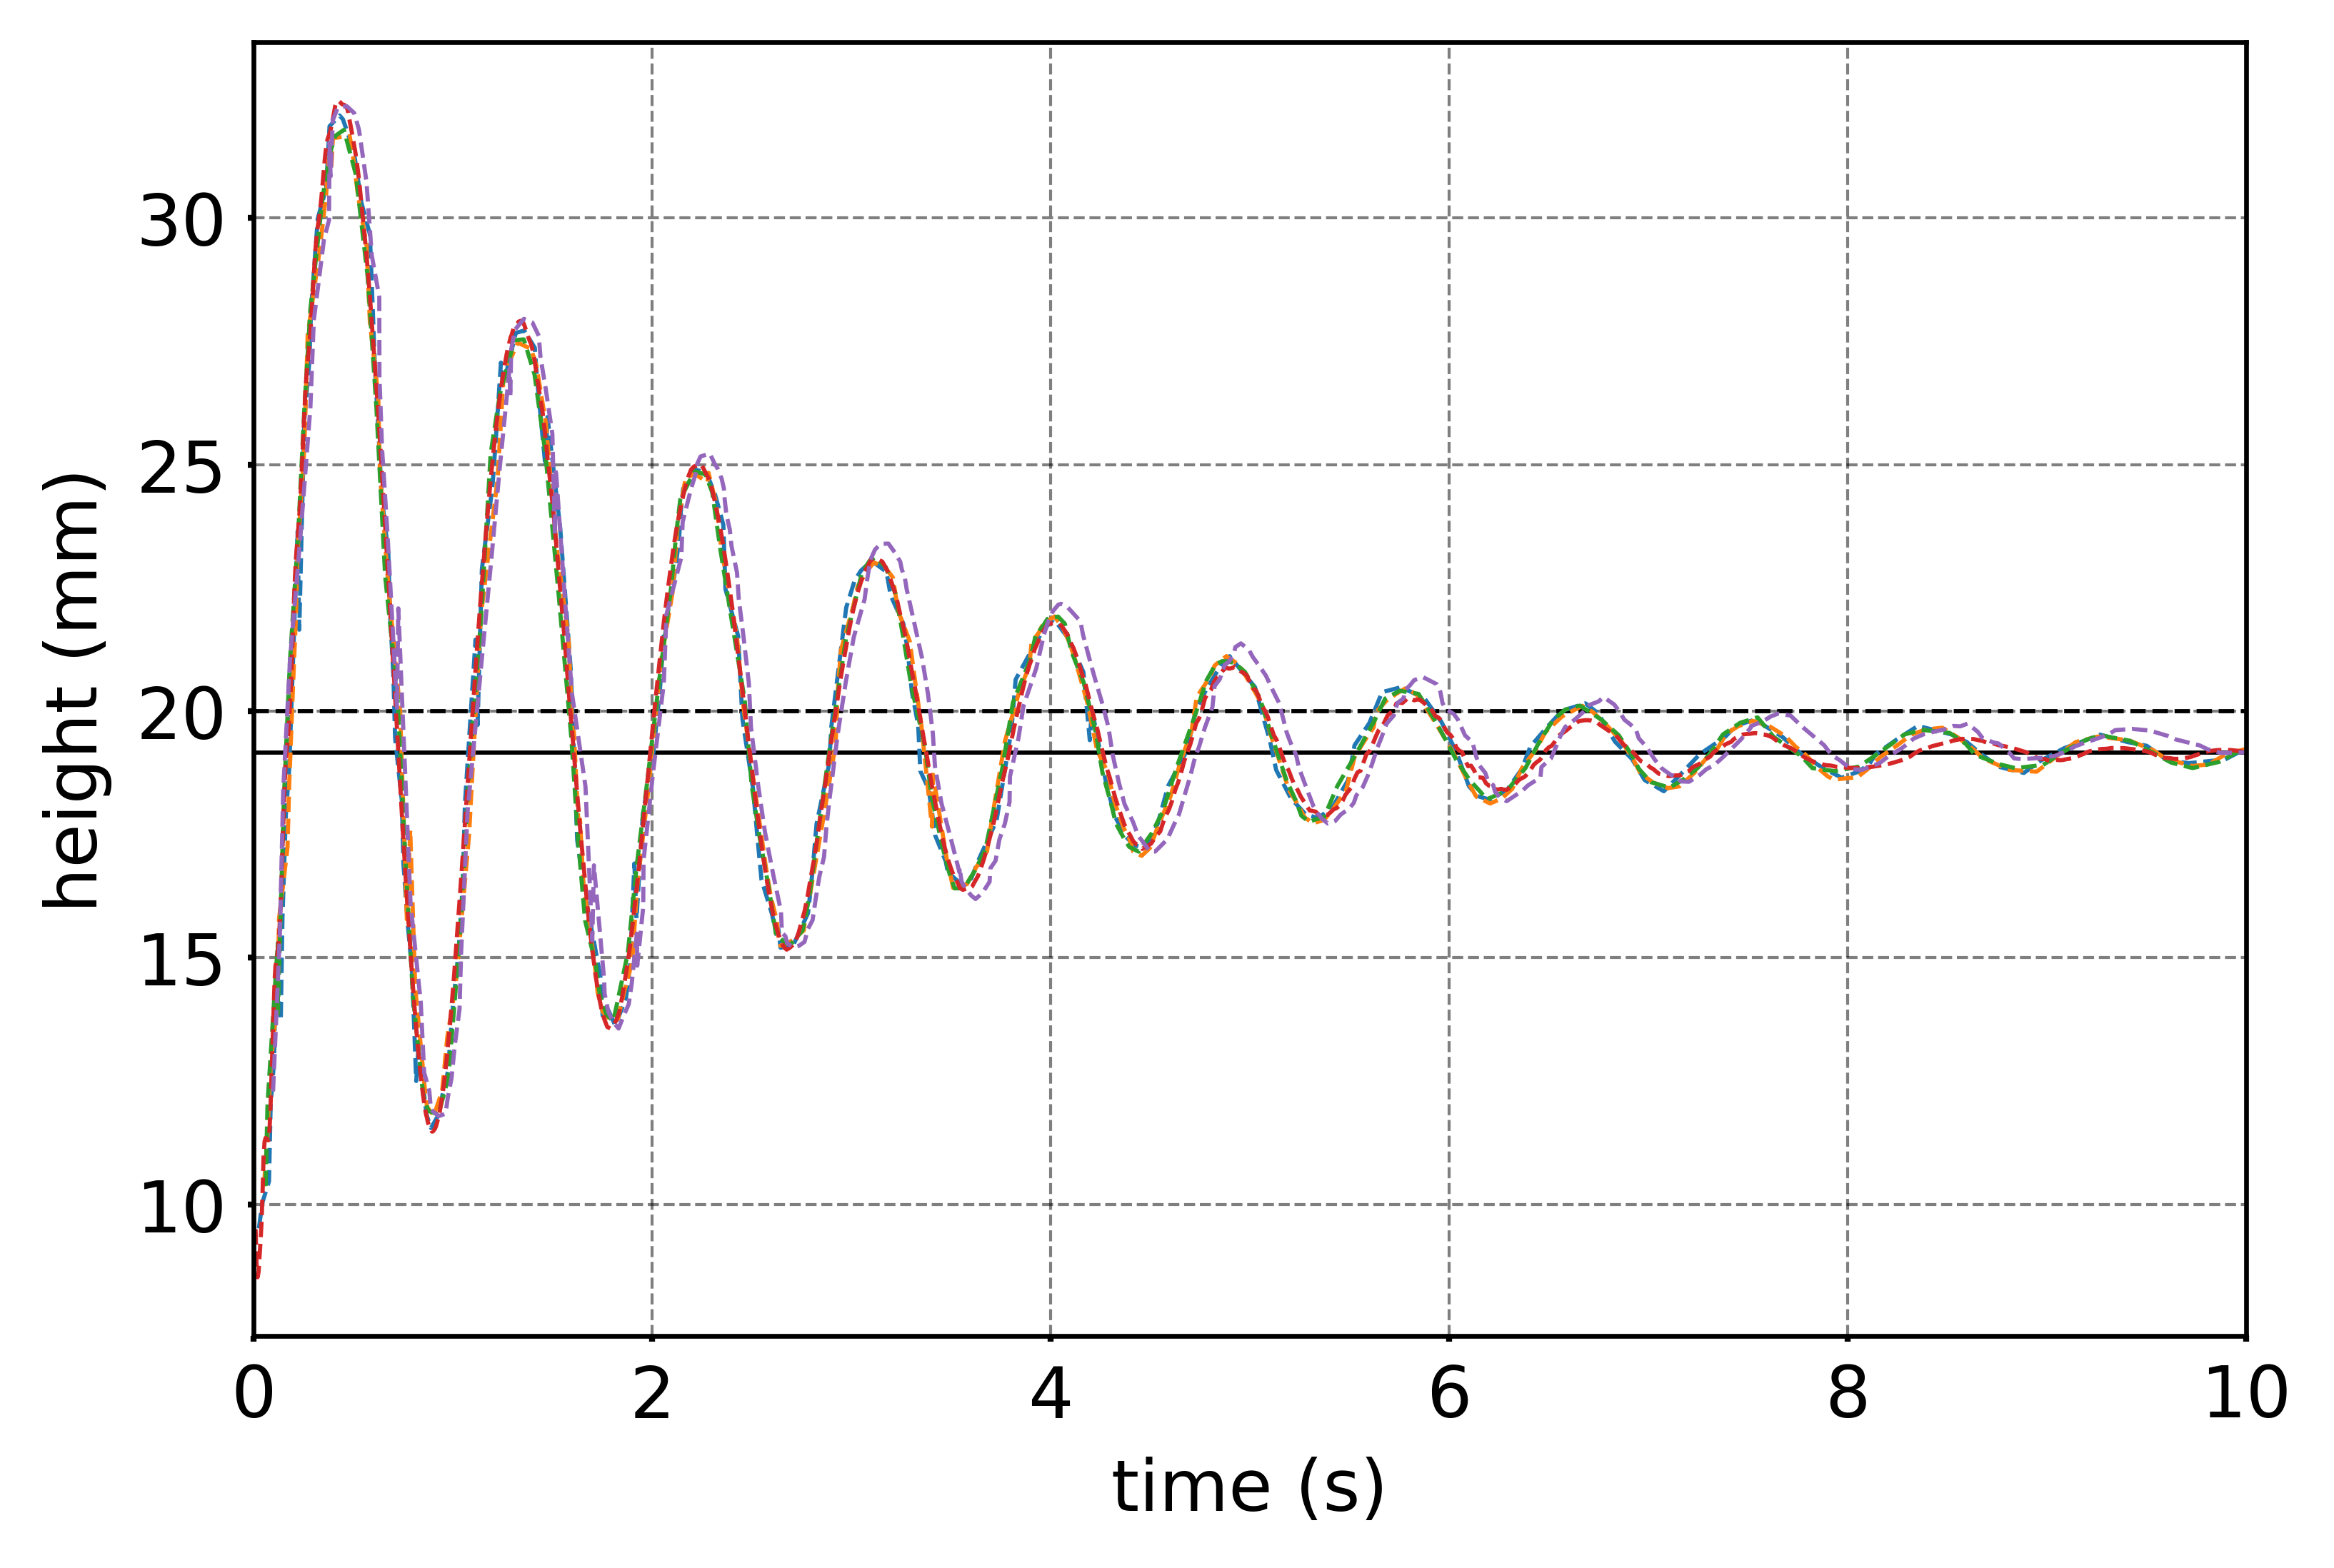

In [4]:
dataFolder = "Omega0.1" #simulation folders
folder = "/numericalMethodComparisonPlots/" #folder containing the csv files from other numerical methods

#Reference solution line
plt.axhline(h_j*1000.0, color='black', linewidth=0.7,linestyle='dashed', label = "Jurins height")
#Reference solution line
plt.axhline(h_apex*1000.0, color='black', linewidth=0.7, label = "corrected rise height")

###################################################################################################################
#File structure
def fileStructure():   
    pattern = '.csv'
    cwd = os.getcwd()
    fileNames = [cwd + folder +dataFolder +  "/" + fd for fd in os.listdir(cwd + folder +dataFolder) if pattern in fd]    
    return(fileNames)   

##################################################################################################################
    
FileNames = fileStructure()
FileNames.sort()
print(FileNames)

##################################################################################################################

#Plot equilibrium spread against static contact angle
labels=["ALE" , "BoSSS", "FS3d" , "interFlow" , "interFoam"] #cells per radius for the simulaitons

for idx, File in enumerate(FileNames):
    pd.set_option('display.float_format', lambda x: '%.1f' % x)
    df = pd.read_csv(File, index_col = 0)
    plt.plot(df, linewidth=0.7, label=labels[idx], ls ='dashed')
    plt.grid(b=True, which='major', color='black',linestyle='dashed', alpha=0.5, lw=0.5)
    plt.grid(b=True, which='minor', color='black', alpha=0.5, lw=0.5)
    plt.tick_params(axis='both', direction='out', length=1, width=1,  grid_color='black', grid_alpha=0.5)
    #plt.title(r'Capillary height - $\Omega=0.1$', fontsize=fontSize)
    plt.xlabel("time (s)" ,color='black',fontsize=fontSize)
    plt.ylabel("height (mm)",color='black',fontsize=fontSize)
    #plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0), ncol=2, fontsize=fontSize)
    plt.xticks(color='black',size = fontSize)
    plt.yticks(color='black',size = fontSize)
    plt.xlim([0, 10])
    plt.ticklabel_format(axis="y", style="plain", useOffset=False)
    plt.rc('font', size=fontSize)

plt.savefig('capillary-rise-Omega_0_1'+'.png', bbox_inches='tight')
plt.savefig('capillary-rise-Omega_0_1'+'.pdf', bbox_inches='tight')
plt.show()
#######################################################################################


## $\Omega=0.5$

['/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.5/ALE.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.5/BoSSS.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.5/FS3D.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.5/interFlow.csv', '/home/asghar/ma11kuba/OpenFOAM-cases/b01-wetting-benchmark/2DCapillaryRiseTest/numericalMethodComparisonPlots/Omega0.5/interFoam.csv']


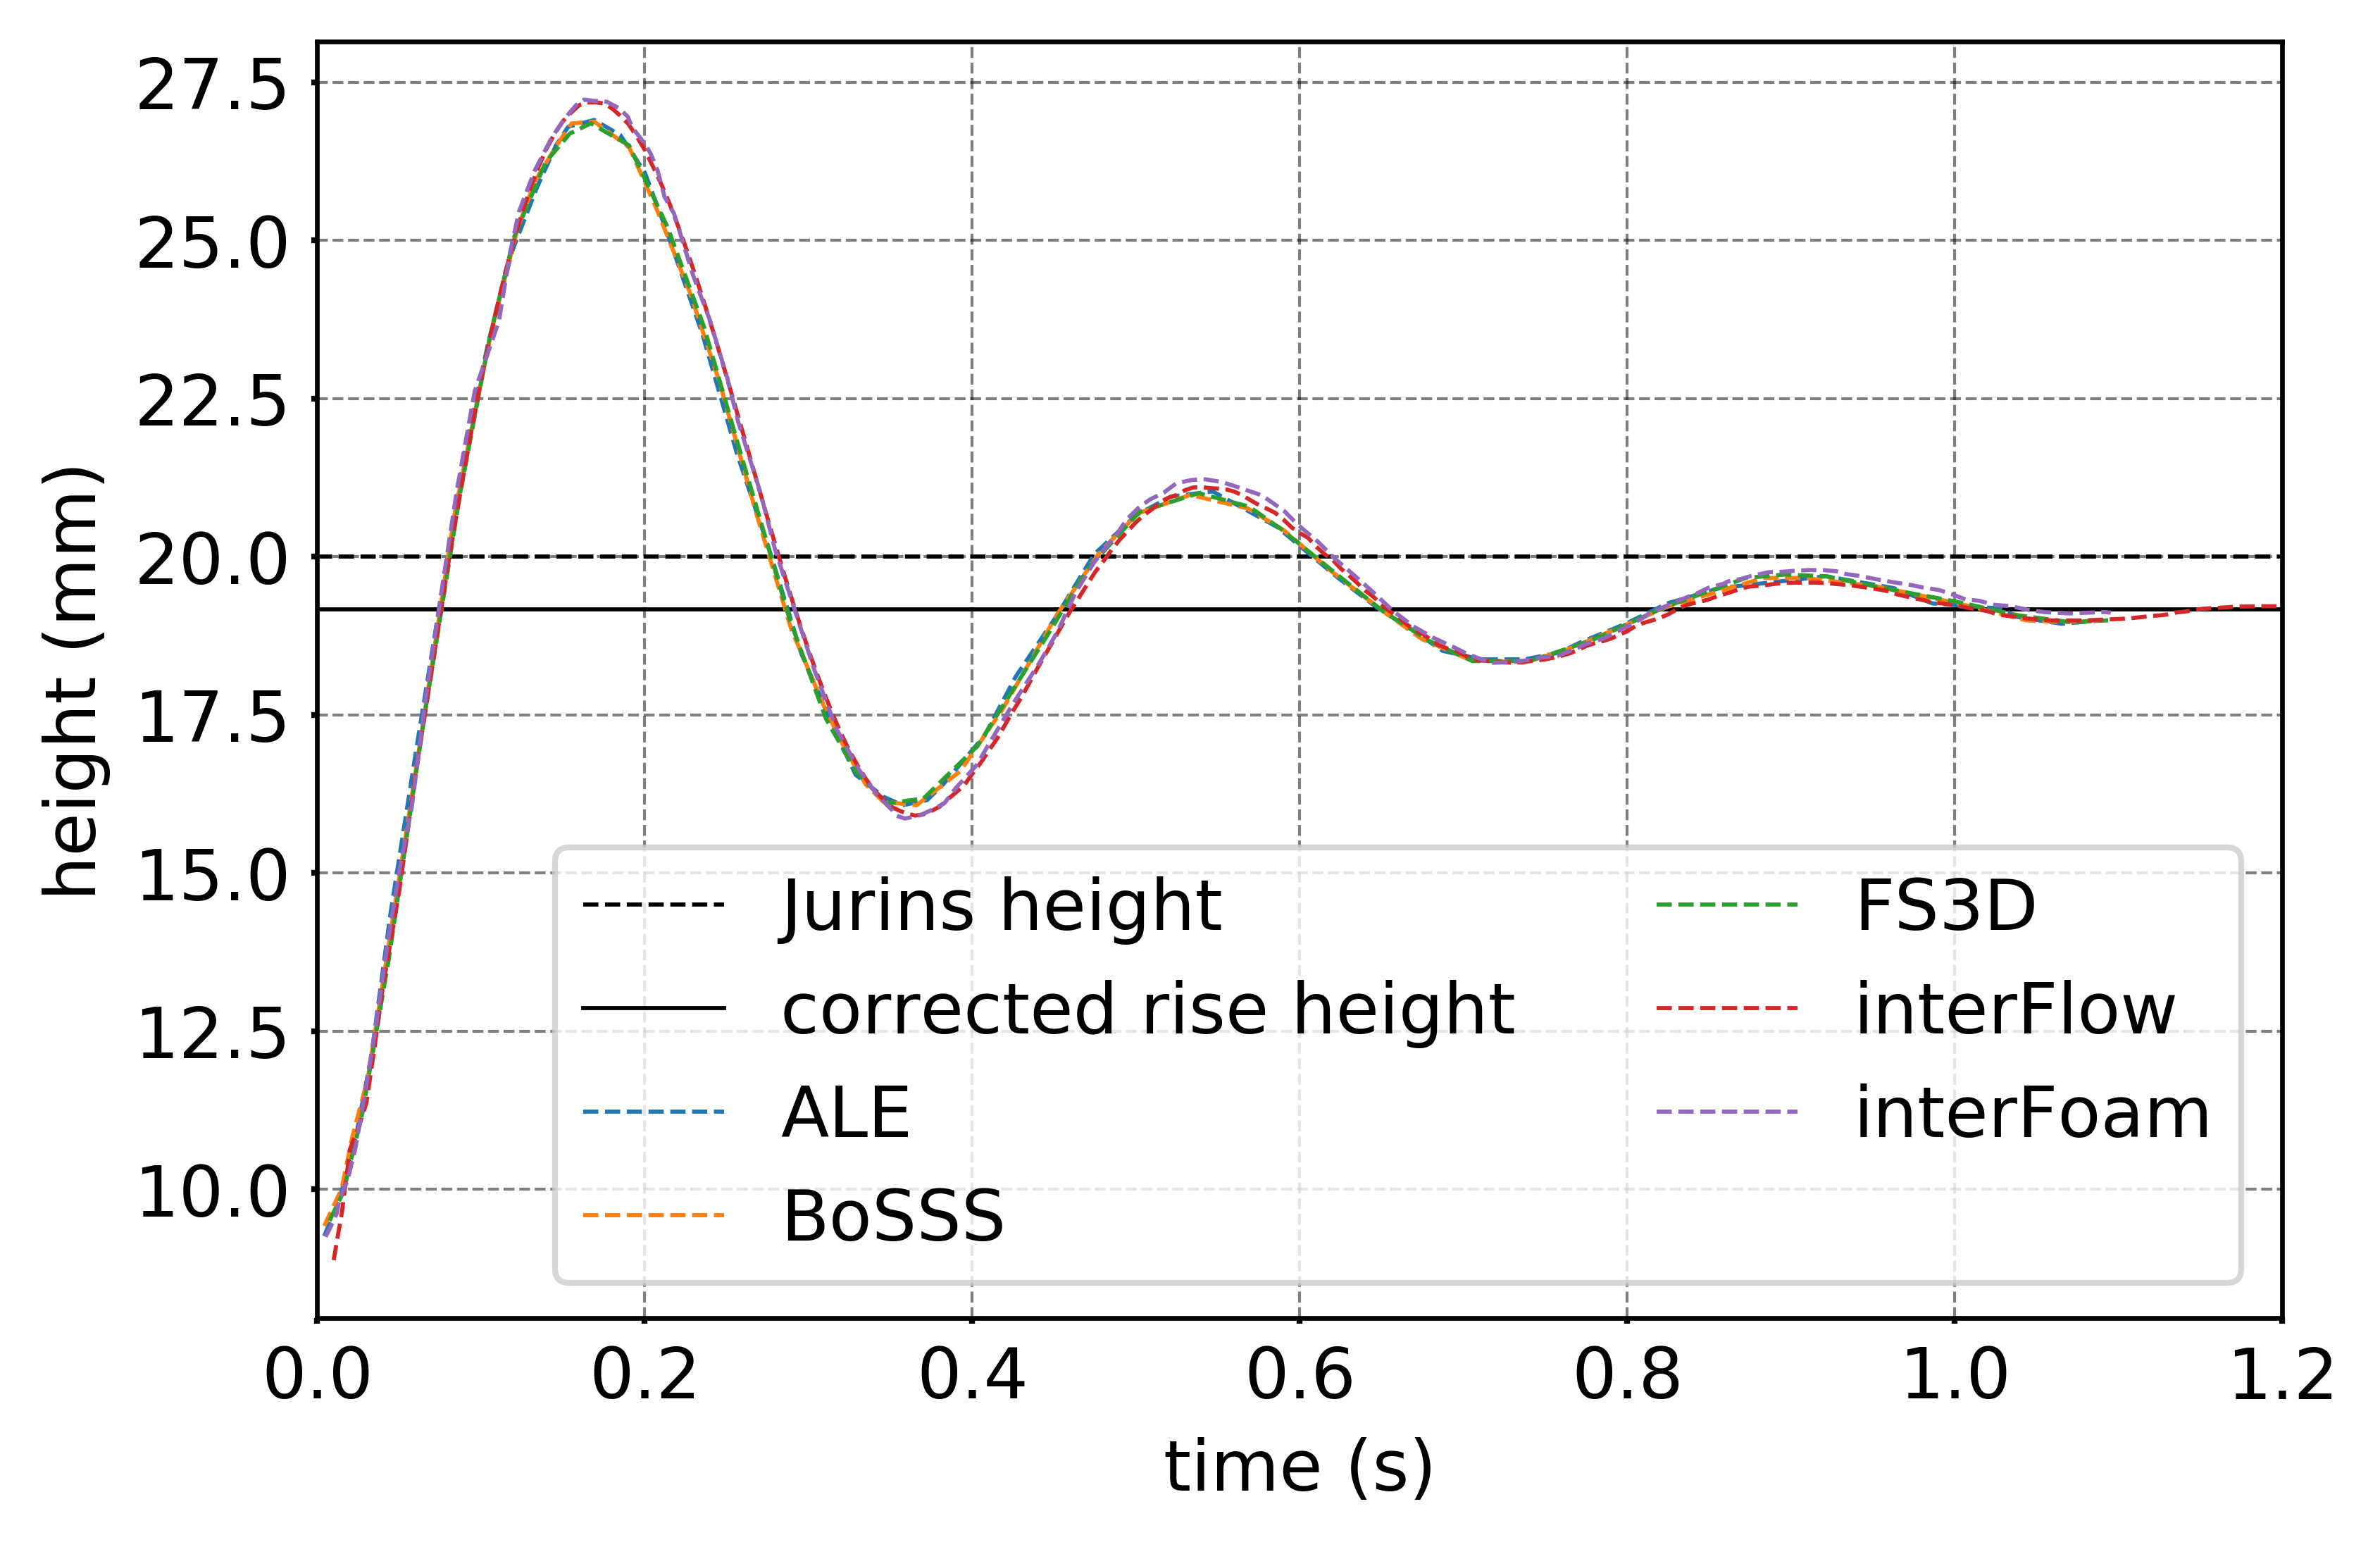

In [5]:
dataFolder = "Omega0.5" #simulation folders
folder = "/numericalMethodComparisonPlots/" #folder containing the csv files from other numerical methods

#Reference solution line
plt.axhline(h_j*1000.0, color='black', linewidth=0.7,linestyle='dashed', label = "Jurins height")
#Reference solution line
plt.axhline(h_apex*1000.0, color='black', linewidth=0.7, label = "corrected rise height")

###################################################################################################################
#File structure
def fileStructure():   
    pattern = '.csv'
    cwd = os.getcwd()
    fileNames = [cwd + folder +dataFolder +  "/" + fd for fd in os.listdir(cwd + folder +dataFolder) if pattern in fd]    
    return(fileNames)   

##################################################################################################################    
FileNames = fileStructure()
FileNames.sort()
print(FileNames)
##################################################################################################################

#Plot equilibrium spread against static contact angle
labels=["ALE" , "BoSSS", "FS3D" , "interFlow" , "interFoam"] #cells per radius for the simulaitons

for idx, File in enumerate(FileNames):
    pd.set_option('display.float_format', lambda x: '%.1f' % x)
    df = pd.read_csv(File, index_col = 0) 
    plt.plot(df, linewidth=0.7, label=labels[idx], ls ='dashed')
    plt.grid(b=True, which='major', color='black',linestyle='dashed', alpha=0.5, lw=0.5)
    plt.grid(b=True, which='minor', color='black', alpha=0.5, lw=0.5)
    plt.tick_params(axis='both', direction='out', length=1, width=1,  grid_color='black', grid_alpha=0.5)
    #plt.title(r'Capillary height - $\Omega=0.5$', fontsize=fontSize)
    plt.xlabel("time (s)" ,color='black',fontsize=fontSize)
    plt.ylabel("height (mm)",color='black',fontsize=fontSize)
    plt.legend(loc='lower center', bbox_to_anchor=(0.55, 0), ncol=2, fontsize=fontSize)
    plt.xticks(color='black',size = fontSize)
    plt.yticks(color='black',size = fontSize)
    plt.xlim([0, 1.2])
    plt.ticklabel_format(axis="y", style="plain", useOffset=False)
    plt.rc('font', size=fontSize)

plt.savefig('capillary-rise-Omega_0_5'+'.png', bbox_inches='tight')
plt.savefig('capillary-rise-Omega_0_5'+'.pdf', bbox_inches='tight')
plt.show()
#######################################################################################
